# Toy problem: classification of colored dots

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
%matplotlib inline

We choose the sizes of the training set, cross-validation set, test set.

In [2]:
coeff = 5
m_train = 60*coeff # number of examples in training set
m_cv = 20*coeff # number of examples in cross validation set
m_test = 20*coeff # number of examples in test set
m_tot = m_train + m_cv + m_test
n = 2 # number of features

We plot the data.

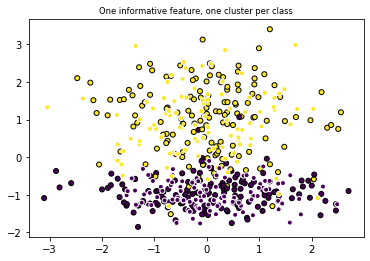

In [3]:
# from https://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html
plt.figure()
plt.title("One informative feature, one cluster per class", fontsize="small")
X1, Y1 = make_classification(
    n_samples=m_tot, n_features=n, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:m_train, 0], X1[:m_train, 1], marker="o", c=Y1[:m_train], s=25, edgecolor="k")
plt.scatter(X1[m_train:m_tot, 0], X1[m_train:m_tot, 1], marker="o", c=Y1[m_train:m_tot], s=25, edgecolor="w")
plt.show()

We split the data (X,y) in the training, cross-validation and test sets.

In [4]:
X_train = torch.tensor(X1[:m_train, :], dtype = torch.float)
X_cv = torch.tensor(X1[m_train:m_train+m_cv, :], dtype = torch.float)
X_test = torch.tensor(X1[m_train+m_cv:m_tot, :], dtype = torch.float)

y_train = torch.tensor(Y1[:m_train], dtype = torch.float).view(m_train, 1)
y_cv = torch.tensor(Y1[m_train:m_train+m_cv], dtype = torch.float).view(m_cv, 1)
y_test = torch.tensor(Y1[m_train+m_cv:m_tot], dtype = torch.float).view(m_test, 1)

Our model will be a neural network with one hidden layer and with sigmoid activation function.

In [5]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    acti = torch.nn.Sigmoid()
    #acti = torch.nn.ReLU()
    h_acti = acti(self.linear1(x))
    y_pred = acti(self.linear2(h_acti))
    return y_pred

We define the training function.

In [6]:
N, D_in, H, D_out = m_train, n, 100, 1

def trainBuildIn(model, X, y, num_iter):
    J_value = np.zeros(num_iter)

    diff = 999
    it = 1
    
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    J_value[0] = loss.item()
    
    print("Loss start training: {:.4f}".format(J_value[0]))
    
    #while (it <= num_iter) and (diff > 0.001):
    while it < num_iter: 

        loss.backward()              # computes gradient of loss wrt parameters
#        for param in model.parameters():
#            print(param,param.grad)
        
        optimizer.step()             # updates parameter using the gradient
        optimizer.zero_grad()
        
        y_pred = model(X)            # compute prediction with current parameters
        loss = loss_fn(y_pred, y)    # compute corresponding loss
        
        J_value[it] = loss.item()    # store loss value
        
        diff = abs(J_value[it] - J_value[it-1])
        it += 1
    
    print("Difference btw two subsequent loss evaluations: {:.4f}".format(diff))
    print("Loss end training: {:.4f}".format(J_value[it-1]))
    return J_value[:it-1]

We train networks with different learning rates and compute the corresponding error in the cross-validation set.

In [7]:
alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1] # learning rate
nb_alphas = len(alphas)
#alphas = [0.1] # learning rate
num_iter = 1000

models = []
optimizers = []
J_values = []
loss_fn = torch.nn.BCELoss()
error_cv = np.zeros(nb_alphas)

for kk in range(nb_alphas):
    alpha = alphas[kk]
    print("Training with learning rate "+ str(alpha) + ":")
    model = TwoLayerNet(D_in, H, D_out)
    models.append(model)
    optimizer = torch.optim.SGD(model.parameters(), lr = alpha)
    optimizers.append(optimizer)
    J_value = trainBuildIn(model, X_train, y_train, num_iter)
    J_values.append(J_value)
    
    y_pred_cv = model(X_cv)
    loss_cv = loss_fn(y_pred_cv, y_cv)
    error_cv[kk] = loss_cv.item()
    print("Cross validation error: {:.4f}".format(error_cv[kk]))
    print('x---x---x---x')
#lam = 0.001

Training with learning rate 0.001:
Loss start training: 0.6989
Difference btw two subsequent loss evaluations: 0.0001
Loss end training: 0.5403
Cross validation error: 0.5513
x---x---x---x
Training with learning rate 0.003:
Loss start training: 0.7164
Difference btw two subsequent loss evaluations: 0.0001
Loss end training: 0.4127
Cross validation error: 0.4244
x---x---x---x
Training with learning rate 0.01:
Loss start training: 0.7022
Difference btw two subsequent loss evaluations: 0.0001
Loss end training: 0.2764
Cross validation error: 0.2797
x---x---x---x
Training with learning rate 0.03:
Loss start training: 0.7469
Difference btw two subsequent loss evaluations: 0.0000
Loss end training: 0.2159
Cross validation error: 0.1983
x---x---x---x
Training with learning rate 0.1:
Loss start training: 0.6741
Difference btw two subsequent loss evaluations: 0.0000
Loss end training: 0.2053
Cross validation error: 0.1758
x---x---x---x
Training with learning rate 0.3:
Loss start training: 0.660

Using the cross-validtion error, we choose the best learning rate. For the corresponding model, we compute the error in the test set, which will be our approximation of the generalization error.

In [8]:
# choose param
print("Choosing the model:")
best_idx = np.argmin(error_cv)
model = models[best_idx]
y_pred_test = model(X_test)
loss_test = loss_fn(y_pred_test, y_test)
error_test = loss_test.item()
print("The best learning rate is: {:.4f}".format(alphas[best_idx]))
print("With corresponding cross-validation error: {:.4f}".format(error_cv[best_idx]))
print("The generatization error is: {:.4f}".format(error_test))

Choosing the model:
The best learning rate is: 0.3000
With corresponding cross-validation error: 0.1733
The generatization error is: 0.2104


We plot the evolution of the loss during training for our chosen model (best learning rate).

0.6600006818771362
0.2038542926311493


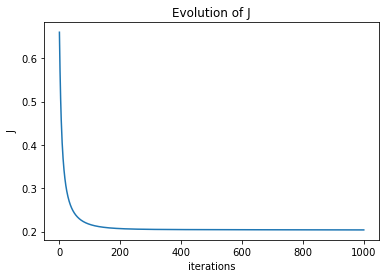

In [9]:
J_value = J_values[best_idx]
print(J_value[0])
print(J_value[-1])
plt.title("Evolution of J") 
plt.xlabel("iterations") 
plt.ylabel("J") 
plt.plot(np.arange(1, J_value.size+1, 1), J_value) 
plt.show()

We plot the classification probaility for our chosen model (best learning rate).

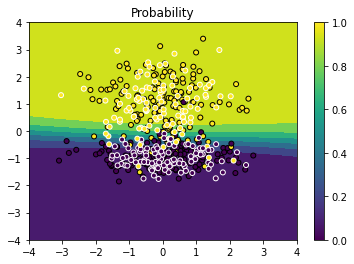

In [10]:
num_steps = 201
plot_range = (-4, 4)
_x = np.linspace(plot_range[0], plot_range[1], num_steps)
_y = np.linspace(plot_range[0], plot_range[1], num_steps).T
fig = plt.figure()
X_new, Y_new = np.meshgrid(_x,_y)
Xfull = torch.tensor(np.c_[X_new.ravel(), Y_new.ravel()], dtype = torch.float, requires_grad = False)
probas = model(Xfull).view(num_steps, num_steps).detach()
plt.contourf(X_new, Y_new, probas)
plt.scatter(X1[:m_train, 0], X1[:m_train, 1], marker="o", c=Y1[:m_train], s=25, edgecolor="k")
plt.scatter(X1[m_train:m_tot, 0], X1[m_train:m_tot, 1], marker="o", c=Y1[m_train:m_tot], s=25, edgecolor="w")
plt.title("Probability")
plt.colorbar()
plt.show()